In [1]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import *
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

<h3> Structure:</h3>
<h4>
    1. Data Preprocessing<br><br>
    2. Processing helper functions<br><br>
    3. MLP<br><br>
    4. CDAE<br><br>
    5. Compare<br><br>
</h4>

<h4>What is the data looks like?</h4>
It is the ml-100k data. The file <strong>u.data</strong> is what we used. The structure is <strong>UserID</strong>; <strong>MovieID</strong>, <strong>rating(1-5)</strong> and the <strong>timestamp</strong>

![images](./images/data.png)

<strong>Reference: </strong>
1. He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. 2017.
2. Wu, Chao-Yuan, et al. "Recurrent recommender networks." Proceedings of the tenth ACM international conference on web search and data mining. 2017.
3. Sedhain, Suvash, et al. "Autorec: Autoencoders meet collaborative filtering." Proceedings of the 24th international conference on World Wide Web. 2015.
4. Wu, Yao, et al. "Collaborative denoising auto-encoders for top-n recommender systems." Proceedings of the Ninth ACM International Conference on Web Search and Data Mining. 2016.
5. blog https://www.cnblogs.com/RoyalFlush/p/12857987.html
6. blog https://blog.csdn.net/qq_35799003/article/details/84780289

<strong>Note:</strong> Many parts of the codes directly come from the implementation of the paper. I modified them to work with TF2.3.0 instead of TF1.0 and add comments to each part of it.

<h3>Data Preprocessing Helper Functions</h3>

In [2]:
# Use to get information from the u.data, output N is #user; M is #movie, data is the dataset
def load_data(file_dir):  
    user_ids_dict, rated_item_ids_dict = {},{} #Set two dictionaries so we can count number under the same key(UserID)
    N, M, u_idx, i_idx = 0, 0, 0, 0 
    data = []
    f = open(file_dir)
    for line in f.readlines():
        u, i, r, _ = line.split() # Split the data frame.
        if int(u) not in user_ids_dict: # If a new user comes in.
            user_ids_dict[int(u)]=u_idx # Build a new key for the new user.
            u_idx+=1 # Add 1 since we spot a new user. The u_idx will finally reflect the number of users.
        if int(i) not in rated_item_ids_dict: # Same procedure but for item.
            rated_item_ids_dict[int(i)]=i_idx
            i_idx+=1
        data.append([user_ids_dict[int(u)],rated_item_ids_dict[int(i)],float(r)]) # Build a list for the user and movie
    f.close()
    N = u_idx
    M = i_idx
    return N, M, data, rated_item_ids_dict

# Create a matrix to map every user (row index) to every movie(column Index). Value at [A,B] is person A's rating of movie B.
def sequence2mat(sequence, N, M):
    # input:
    # sequence: the list of rating information
    # N: row number, i.e. the number of users
    # M: column number, i.e. the number of items
    # output:
    # mat: user-item rating matrix
    records_array = np.array(sequence)
    mat = np.zeros([N,M]) 
    # We create a matrix with N rows and M columns. Hence we can see the rating of PersonA on MovieB at poistion [A, B] in the matrix.    
    row = records_array[:,0].astype(int) # Send in the row index
    col = records_array[:,1].astype(int) # Send in the column index
    values = records_array[:,2].astype(np.float32) 
    mat[row,col]=values # Send in the value.
    return mat # We get a matrix (row:userID, column:movieID, the value at any position of the matrix: the corresponding rating)

### Data Training Helper Functions

In [3]:
# Get the first 10 most likely prediction(what movie a user want to see).
# Calculate the correct hit based on this.
def get_topn(r_pred, train_mat, n=10):
    unrated_items = r_pred * (train_mat==0)
    idx = np.argsort(-unrated_items)
    return idx[:,:n]

# Calculate recall and precision.
def recall_precision(topn, test_mat):
    n,m = test_mat.shape # Get the shape of test_mat, where n and m are user number and movide number respectively
    hits,total_pred,total_true = 0.,0.,0.  # Define 0. to make these numeric values float.
    for u in range(n):
        hits += len([i for i in topn[u,:] if test_mat[u,i]>0]) # calculate hits. 
        size_pred = len(topn[u,:])
        size_true = np.sum(test_mat[u,:]>0,axis=0)
        total_pred += size_pred
        total_true += size_true

    recall = hits/total_true
    precision = hits/total_pred
    return recall, precision

# Calculate mean absolute error and root mean squared error.
def mae_rmse(r_pred, test_mat):
    y_pred = r_pred[test_mat>0] 
    # Use >0 here because we want to ignore 0 values. 
    # The movies which have never been watched were also marked as 0 so we need to ignore them.
    y_true = test_mat[test_mat>0]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse 

# Call mae_rmse and recall_precision to evaluate the model
def evaluation(pred_mat, train_mat, test_mat):
    topn = get_topn(pred_mat, train_mat, n=10)
    mae, rmse = mae_rmse(pred_mat, test_mat)
    recall, precision = recall_precision(topn, test_mat)
    return mae, rmse, recall, precision

# Calculate hit number.
def get_hit(ranklist,rated_item):
    result = 0
    for item in ranklist:
        if item==rated_item:
            result = 1 # If the rank list matched then set result to 1 (set to 0 if no match). Output the result. 
    return result
    
# NDCG is then the ratio of DCG of recommended order to DCG of ideal order. 
# This ratio will always be in the range [0,1].
# Reference: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
def get_ndcg(ranklist,rated_item):
    result = 0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item==rated_item:
            result = math.log(2)/math.log(i+2)
    return result

# Reference: https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
# Call get_ndcg to compute the ratio of DCG of recommended order to DCG of ideal order. 
def hit_ndcg(test_sequence, ranklist):
    length = len(test_sequence)
    hits,ndcgs=[],[]
    for idx in range(length):
        user = test_sequence[idx,0].astype(np.int32)
        rated_item = test_sequence[idx,1].astype(np.int32)
        hr = get_hit(ranklist[user],rated_item)
        ndcg = get_ndcg(ranklist[user],rated_item)
        hits.append(hr)
        ndcgs.append(ndcg)
    return hits,ndcgs

# Output figure.
def figure(values_list, name=''):
    fig=plt.figure(name)
    x = range(len(values_list))
    plot(x, values_list, color='g',linewidth=3)
    plt.title(name + ' curve')
    plt.xlabel('Iterations')
    plt.ylabel(name)
    show()

In [4]:
# The model for MLP
class mlp():
    def __init__(self,               
                 users_num = None, # User number
                 items_num = None, # Movie number
                 embedding_size = 16, # embedding_size
                 hidden_sizes = [16,8], # hidden units
                 learning_rate = 1e-3, # learning rate
                 lamda_regularizer=1e-3, # regularization
                 batch_size = 256 # batch size 
                ):
        self.users_num = users_num
        self.items_num = items_num
        self.embedding_size = embedding_size
        self.hidden_sizes = hidden_sizes
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.batch_size = batch_size

        # loss records
        self.train_loss_records = []  
        self.build_graph()   

    # This function is the main part of defining a Deep Neural Network. All the functions below this part is called
    # inside this main function.
    # Procedure:
    # 1. Define place holder (redundant for TF2.0)
    # 2. Set weights
    # 3. Send in data and feed forward. Calculate the loss
    # 4. Set optimizer (to back propagation and update weights)
    # 5. Make predictions
    # 6. Finally start the session
    
    def build_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():       
            # Define place holder. The is redudant for TF2.0 tho but all the learning material use the older version
            # so I didn't change this part. 
            self.users_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None], name='users_inputs')
            self.items_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None], name='items_inputs')
            self.train_labels = tf.compat.v1.placeholder(tf.float32, shape = [None], name='train_labels') 
            
            # Set weights
            self.weights = self._initialize_weights()
            
            # Training(feed forward)
            self.y_ = self.inference(users_inputs=self.users_inputs, items_inputs=self.items_inputs)
            self.loss_train = self.loss_function(true_labels=self.train_labels, 
                                                 predicted_labels=tf.reshape(self.y_,shape=[-1]),
                                                 lamda_regularizer=self.lamda_regularizer)
            
            # Set Adam as optimizer (back propagation)
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate,beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(self.loss_train) 

            # Make Predictions 
            self.predictions = self.inference(users_inputs=self.users_inputs, items_inputs=self.items_inputs)
        
            # Initiliazation and run
            init = tf.compat.v1.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
    
    
    def _init_session(self):
        # Use TF GPU
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        return tf.compat.v1.Session(config=config)
    
    
    def _initialize_weights(self):
        all_weights = dict()

        # We use an embedding layer here. We do this because the user vector (The row in the matrix) and the movie vectors
        # are too sparse(Every user only see several movies and make the vector have 0 in most places) 
        # The dimension space is so huge that we need to map the original vector to a smaller space with most
        # of the information stored. This will help the training.
        all_weights['embedding_users'] = tf.Variable(tf.random.normal([self.users_num, self.embedding_size],0, 0.1),name='embedding_users')
        all_weights['embedding_items'] = tf.Variable(tf.random.normal([self.items_num, self.embedding_size],
                                                                      0, 0.1),name='embedding_items') 
        
        # hidden layer (get two layers with bias)
        # weight_0 & bias_0 for layer1.
        # weight_1 & bias_1 for layer2.
        all_weights['weight_0'] = tf.Variable(tf.random.normal([self.embedding_size * 2,self.hidden_sizes[0]], 0.0, 0.1),name='weight_0')
        all_weights['bias_0'] = tf.Variable(tf.zeros([self.hidden_sizes[0]]), name='bias_0')
        all_weights['weight_1'] = tf.Variable(tf.random.normal([self.hidden_sizes[0],self.hidden_sizes[1]], 0.0, 0.1), name='weight_1')
        all_weights['bias_1'] = tf.Variable(tf.zeros([self.hidden_sizes[1]]), name='bias_1')
        
        # output layer
        all_weights['weight_n'] = tf.Variable(tf.random.normal([self.hidden_sizes[-1], 1], 0, 0.1), name='weight_n')
        all_weights['bias_n'] = tf.Variable(tf.zeros([1]), name='bias_n')
        return all_weights
        
    
    def train(self, data_sequence):
        train_size = len(data_sequence) # The total feed in data for one time.
        batch_size = self.batch_size # size of a single batch
        total_batch = math.ceil(train_size/batch_size) # how many batches in a epoch

        for batch in range(total_batch):
            start = (batch * batch_size)% train_size 
            # Where to start in the data_sequence. It is cumulative so we need batch * batch_size(how many data
            # has already been processed. (batch * batch_size)% train_size: how many processed data exceed the last whole batch
            # and start from that position.
            end = min(start+batch_size, train_size) # take care of the edge cases
            data_array = np.array(data_sequence[start:end])
            X = data_array[:,:2] # features
            y = data_array[:,-1] # labels
            feed_dict = {self.users_inputs: X[:,0], self.items_inputs: X[:,1], self.train_labels:y} # Build a dic for the input
            loss, opt = self.sess.run([self.loss_train,self.train_op], feed_dict=feed_dict) # Get loss
            self.train_loss_records.append(loss)
        return self.train_loss_records

        
    # Feed forward.
    def inference(self, users_inputs, items_inputs):
        # Use embedding layers to deal with huge sparse user and item vectors.
        # We can notice that most parts of the vector of a user(a row in the user-item rating matrix) are zero
        # hence the data is very sparse. We need to map such high dimentional data (1*1682) into a smaller space.
        # This is why we need embedding.
        embed_users = tf.reshape(tf.nn.embedding_lookup(self.weights['embedding_users'], users_inputs),
                                 shape=[-1, self.embedding_size])
        embed_items = tf.reshape(tf.nn.embedding_lookup(self.weights['embedding_items'], items_inputs),
                                 shape=[-1, self.embedding_size])
        
        # Two layers of MLP, activation function ReLu (sigmoid also works)
        layer0 = tf.nn.relu(tf.matmul(tf.concat([embed_items,embed_users],1), self.weights['weight_0']) + self.weights['bias_0'])
        layer1 = tf.nn.relu(tf.matmul(layer0, self.weights['weight_1']) + self.weights['bias_1'])       
        y_ = tf.matmul(layer1,self.weights['weight_n']) + self.weights['bias_n']
        return y_         
        
        
    # Define loss function, type: MSE
    def loss_function(self, true_labels, predicted_labels,lamda_regularizer=1e-3):   
        loss = tf.compat.v1.losses.mean_squared_error(true_labels, predicted_labels)
        cost = loss
        if lamda_regularizer>0:
            regularizer_1 = tf.keras.regularizers.l2(lamda_regularizer)
            regularization = regularizer_1( # Add regularization term to each part of the weights.
                self.weights['embedding_users']) + regularizer_1(
                self.weights['embedding_items'])+ regularizer_1(
                self.weights['weight_0']) + regularizer_1(
                self.weights['weight_1']) + regularizer_1(
                self.weights['weight_n'])
            # We add regularizations to the weights. Thus we reduces the impact of the weights and reduce overfitting.
            # The model is very simply here so regularization is quite redundant.
            # But still keep the code to show the process
            cost = loss + regularization

        return cost   
    
    # Predict the ratings.
    def predict_ratings(self, data_sequence):
        pred_mat = np.zeros([self.users_num, self.items_num]) # first define the size of predition matrix
        instances_size = len(data_sequence) 
        data_array = np.array(data_sequence)
        items_id = np.array([i for i in range(self.items_num)])
        for u in range(self.users_num):
            users_id = u*np.ones_like(items_id)
            feed_dict = {self.users_inputs:users_id, 
                         self.items_inputs:items_id}  
            out = self.sess.run([self.predictions], feed_dict=feed_dict)
            pred_mat[u] = np.reshape(out,(-1))

        return pred_mat

In [5]:
# The model for CDAE (Collaborative Denoising Auto-Encoders)
class cdae():
    def __init__(self,
                 users_num = None,         # User Number
                 items_num = None,         # Item Number
                 hidden_size = 500,        # Hidden units
                 batch_size = 256,         # batch size
                 learning_rate = 1e-3,     # learning rate
                 lamda_regularizer = 1e-3, # regulization
                 dropout_rate = 0.5,       # dropout rate
                 noise_level = 1e-3
                ):
        self.users_num = users_num
        self.items_num = items_num
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.dropout_rate = dropout_rate
        self.noise_level = noise_level
        
        self.train_loss_records = []  
        self.build_graph()   

    # The sekelton of the Neural Network. Call all the helper functions below.
    def build_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():      
            # Input data. Define place holder. (This is redundant with TF2/Keras)
            self.rating_inputs = tf.compat.v1.placeholder(tf.float32, shape = [None, self.items_num], name='rating_inputs')
            self.user_inputs = tf.compat.v1.placeholder(tf.int32, shape = [None, 1], name='user_inputs')
            self.dropout_prob = tf.compat.v1.placeholder(tf.float32, name = "dropout_prob")

            # Set weights. Rememeber we have symmetric layers in auto-encoder.
            self.weights = self._initialize_weights()
            
            # Feed forward and back propagation. Define the loss and optimizer(Adam)
            self.y_ = self.inference(rating_inputs=self.rating_inputs, user_inputs=self.user_inputs)
            self.loss_train = self.loss_function(true_r=self.corrupted_inputs, predicted_r=self.y_, lamda_regularizer=self.lamda_regularizer)
            self.train_op = tf.compat.v1.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(self.loss_train) 
        
            # Make predictions
            self.predictions = self.inference(rating_inputs=self.rating_inputs, user_inputs=self.user_inputs)
            
            # Run the Session
            init = tf.compat.v1.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
    
    
    def _init_session(self):
        # Set up the GPU configuration.
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        return tf.compat.v1.Session(config=config)
    
    # Warning!! Core part of CDAE
    def _initialize_weights(self):
        all_weights = dict()
        # W1 and b1 used for encoder (hidden layer1)
        all_weights['W1'] = tf.Variable(tf.random.normal([self.items_num, self.hidden_size], 0.0, 0.1), name='W1')
        all_weights['b1'] = tf.Variable(tf.zeros([self.hidden_size]), name='b1')
        # W2 and b2 used for decoder (hidden layer2)
        all_weights['W2'] = tf.Variable(tf.random.normal([self.hidden_size, self.items_num], 0.0, 0.1), name='W2')
        all_weights['b2'] = tf.Variable(tf.zeros([self.items_num]), name='b2')
        # Embedding.
        all_weights['V'] = tf.Variable(tf.zeros([self.users_num, self.hidden_size]), name='V')
        return all_weights
    
    # Training
    def train(self, data_mat):
        instances_size = len(data_mat) # The total feed in data for one time.
        batch_size = self.batch_size # size of a single batch
        total_batch = math.ceil(instances_size/batch_size)# how many batches in a epoch
        # Where to start in the data_sequence. It is cumulative so we need batch * batch_size(how many data
        # has already been processed. (batch * batch_size)% train_size: how many processed data exceed the last whole batch
        # and start from that position.
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size) # edge cases
            # Define feed_dic[user, rating, dropouts_prob]
            feed_dict = {self.user_inputs:np.reshape(data_mat[start:end,0],(-1,1)), 
                         self.rating_inputs:data_mat[start:end,1:], 
                         self.dropout_prob:self.dropout_rate}  
            # Calculate the loss. 
            loss, opt = self.sess.run([self.loss_train, self.train_op], feed_dict=feed_dict)# Send in the feed_dic
            self.train_loss_records.append(loss)
            
        return self.train_loss_records

        
    # Feedforward
    def inference(self, rating_inputs, user_inputs):
        # We add some noise in the input. And use drop-out(p=0.5) here.
        # noise: (noise_level = 1e-3) * random normal
        # noise + rating = input (combine the noise and the input together)
        # Thus we can reduce overfitting. 
        inputs_noisy = rating_inputs + self.noise_level * tf.random.normal(tf.shape(rating_inputs))
        self.corrupted_inputs = tf.nn.dropout(inputs_noisy, rate=self.dropout_prob)
        # Add embedding here to map the high dimensional data into lower dimension with their features preserved.
        Vu = tf.reshape(tf.nn.embedding_lookup(self.weights['V'], user_inputs),(-1, self.hidden_size))
        # Encoder - hidden layer1
        encoder = tf.nn.sigmoid(tf.matmul(self.corrupted_inputs, self.weights['W1']) + Vu + self.weights['b1'])
        # Decoder - hidden layer2
        decoder = tf.identity(tf.matmul(encoder, self.weights['W2']) + self.weights['b2'])
        return decoder         
        
        
    def loss_function(self, true_r, predicted_r, lamda_regularizer=1e-3, loss_type='square'):
        idx = tf.where(true_r>0) # Where the values preserved. (We have many zeros which means nothing)
        true_y = tf.gather_nd(true_r, idx) # get true rating
        predicted_y = tf.gather_nd(predicted_r, idx) # predicted rating.
       
        if loss_type== 'square': # Can pick MSE as loss function
            loss = tf.compat.v1.losses.mean_squared_error(true_y, predicted_y)
        elif loss_type== 'cross_entropy': # or cross entropy
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=true_y, logits=predicted_y)
        
        # Add regularizer to each part of the weight to reduce their impact and hence reduce the overfitting.
        # This is a standard block for dealing with regularization.
        regularizer = tf.keras.regularizers.l2(lamda_regularizer)
        regularization = regularizer(self.weights['V']) + regularizer(self.weights['W1']) + regularizer(
            self.weights['W2']) + regularizer(self.weights['b1']) + regularizer(self.weights['b2'])
        cost = loss + regularization
        return cost 
    
    # Do the predictions. It is the same with what happened in MLP
    def predict_ratings(self, data_mat):
        pred_mat = np.zeros([self.users_num, self.items_num])
        
        instances_size = len(data_mat)
        batch_size = self.batch_size
        total_batch = math.ceil(instances_size/batch_size)
        for batch in range(total_batch):
            start = (batch*batch_size)% instances_size
            end = min(start+batch_size, instances_size)
            feed_dict = {self.user_inputs:np.reshape(data_mat[start:end,0],(-1,1)), 
                         self.rating_inputs:data_mat[start:end,1:],
                         self.dropout_prob:0.}  
            out = self.sess.run([self.predictions], feed_dict=feed_dict)
            pred_mat[start:end,:] = np.reshape(out,(-1,self.items_num))

        return pred_mat

### Load the dataset

In [6]:
data_dir = 'datasets/ml-100k/u.data' # user id + item id + rating + timestamp
N, M, data_list, _ = load_data(file_dir=data_dir) # get the user number, movie number and the data(list)
print(' data length: %d \n user number: %d \n movie number: %d' %(len(data_list),N,M))

 data length: 100000 
 user number: 943 
 movie number: 1682


In [7]:
# print(data_list) # [[list1],[list2],[list3]...[listN]] and list1 = [userID, movieID, rating]

In [8]:
print(type(data_list)) # Remember it is a list.

<class 'list'>


### Split the dataset

In [9]:
# Use the sklearn train_test_split method
train_list, test_list = train_test_split(data_list,test_size=0.2)
print ('train length: %d \n test length: %d' %(len(train_list),len(test_list)))

train length: 80000 
 test length: 20000


### Transfer list into matrix

In [10]:
# We transfer the list into a user-movie matrix. See detials in the helper function block.
train_mat = sequence2mat(sequence = train_list, N = N, M = M) 
test_mat = sequence2mat(sequence = test_list, N = N, M = M)

In [11]:
print(train_mat[0,:]) # See the first row, which means the first user's idea about the movies.

[0. 0. 0. ... 0. 0. 0.]


In [12]:
print(np.shape(train_mat)) # 943 Users and 1682 movies.

(943, 1682)


### Parameters Setting

In [13]:
users_num = N            # User number
items_num = M            # Movide number
hidden_size = 500        # Number of hidden units.
batch_size = 256         # batch size
lamda_regularizer = 1e-3 # regularization
learning_rate = 1e-3     # Learning rate
epoches  = 100

# Best embedding size is return 2 * int(np.floor(np.power(n, 0.25))) 
embedding_size = 10

### 1. MLP

epoch:0  loss=13.3399; 
 MAE=3.4917; RMSE=3.6679; Recall=0.0128; Precision=0.0271; Hit=0.0128; NDCG=0.0081
epoch:10  loss=1.3941; 
 MAE=0.8133; RMSE=1.0184; Recall=0.0638; Precision=0.1352; Hit=0.0638; NDCG=0.0294
epoch:20  loss=1.0914; 
 MAE=0.7605; RMSE=0.9578; Recall=0.0457; Precision=0.0970; Hit=0.0457; NDCG=0.0216
epoch:30  loss=1.0356; 
 MAE=0.7504; RMSE=0.9460; Recall=0.0401; Precision=0.0849; Hit=0.0401; NDCG=0.0180
epoch:40  loss=0.9415; 
 MAE=0.7461; RMSE=0.9425; Recall=0.0374; Precision=0.0793; Hit=0.0374; NDCG=0.0163
epoch:50  loss=0.9301; 
 MAE=0.7458; RMSE=0.9411; Recall=0.0362; Precision=0.0769; Hit=0.0362; NDCG=0.0159
epoch:60  loss=0.9039; 
 MAE=0.7463; RMSE=0.9405; Recall=0.0336; Precision=0.0712; Hit=0.0336; NDCG=0.0149
epoch:70  loss=0.8359; 
 MAE=0.7444; RMSE=0.9403; Recall=0.0335; Precision=0.0709; Hit=0.0335; NDCG=0.0149
epoch:80  loss=1.0408; 
 MAE=0.7447; RMSE=0.9400; Recall=0.0313; Precision=0.0664; Hit=0.0313; NDCG=0.0142
epoch:90  loss=0.8266; 
 MAE=0.7463; 

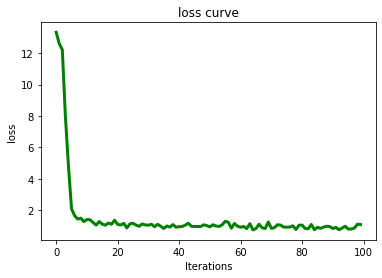

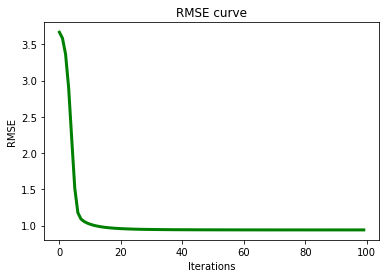

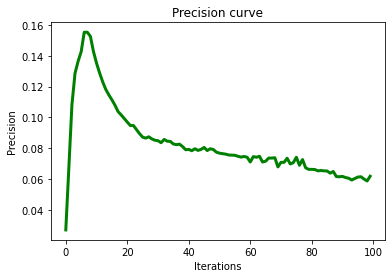

In [14]:
learning_rate = 1e-4  
hidden_sizes = [embedding_size,int(embedding_size/2)]

model = mlp(users_num = users_num,
            items_num = items_num,
            embedding_size = embedding_size,
            hidden_sizes = hidden_sizes,
            learning_rate = learning_rate,
            lamda_regularizer = lamda_regularizer,
            batch_size = batch_size)

records_list = []
input_data = train_list
for epoch in range(epoches):
    data_mat = np.random.permutation(input_data)# Randomly shuffer the input data
    loss = model.train(data_sequence=data_mat) # Send in model and train.
    pred_mat = model.predict_ratings(data_sequence=test_list) # Make predictions based on trained model
    mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat) # Evaluation
    records_list.append([loss[-1], mae, rmse, recall, precision])
    if epoch % 10==0: # Print progress for every 10 epoch
        topn = get_topn(pred_mat, train_mat, n=10) # Evalute the hitting rate by the 10 most likely movie pick.
        hit_list, ndcg_list = hit_ndcg(test_sequence=np.array(test_list), ranklist=topn)
        hit, ndcg = np.array(hit_list).mean(),np.array(ndcg_list).mean()
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f; Hit=%.4f; NDCG=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision, hit, ndcg))

figure(values_list=np.array(records_list)[:,0],name='loss')
figure(values_list=np.array(records_list)[:,2],name='RMSE')
figure(values_list=np.array(records_list)[:,-1],name='Precision')

In [15]:
# print(pred_mat[0,:]) # Let's see what is a prediction row looks like. (The predicted ratings of a person)

### Show the list of recommended movies.

In [16]:
# Given a certain person, let's say the first one in the list. Provide him the recommandation
# It is the highest 10 ratings predicted. 
# The numbers in the list are the indices of the movie in the matrix (not exact movie ID)
# I didn't convert it because the dataset doesn't provide exact movie names anyway.
res = sorted(range(len(pred_mat[0,:])), key = lambda sub: pred_mat[0,:][sub])[-10:] 
print(res)

[541, 1255, 297, 277, 612, 36, 239, 174, 200, 180]


<h4>And the corresponding rating.</h4>

In [18]:
# Take a look at what the ratings exactly are.
import heapq
movie_rating = heapq.nlargest(10, pred_mat[0,:])        
print(movie_rating)

[4.523581027984619, 4.503505229949951, 4.484161853790283, 4.471639156341553, 4.418665885925293, 4.417996883392334, 4.416147708892822, 4.4141764640808105, 4.403722286224365, 4.374261379241943]


<h4>I didn't give the eact movie names because the data set only has the ID of the movies. The names can be found in other files with the corresponding unique ID.</h4>

![images](./images/data.png)

### 2. CDAE
- <strong>User based / Collaborative</strong>

epoch:0  loss=15.1984; 
 MAE=3.0930; RMSE=3.2898; Recall=0.0543; Precision=0.1152
epoch:10  loss=4.2413; 
 MAE=2.1581; RMSE=2.4497; Recall=0.0897; Precision=0.1902
epoch:20  loss=4.1369; 
 MAE=2.1287; RMSE=2.4241; Recall=0.0921; Precision=0.1954
epoch:30  loss=4.1159; 
 MAE=2.1463; RMSE=2.4370; Recall=0.0887; Precision=0.1881
epoch:40  loss=4.2519; 
 MAE=2.1614; RMSE=2.4508; Recall=0.0893; Precision=0.1894
epoch:50  loss=4.0014; 
 MAE=2.1481; RMSE=2.4404; Recall=0.0896; Precision=0.1900
epoch:60  loss=4.5135; 
 MAE=2.1353; RMSE=2.4309; Recall=0.0899; Precision=0.1907
epoch:70  loss=3.8657; 
 MAE=2.1487; RMSE=2.4450; Recall=0.0868; Precision=0.1841
epoch:80  loss=4.2349; 
 MAE=2.1399; RMSE=2.4357; Recall=0.0866; Precision=0.1837
epoch:90  loss=4.0248; 
 MAE=2.1514; RMSE=2.4461; Recall=0.0871; Precision=0.1847


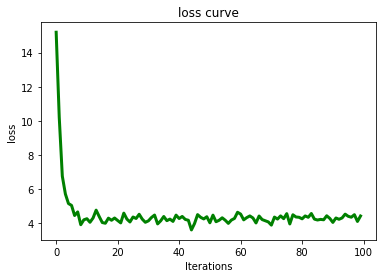

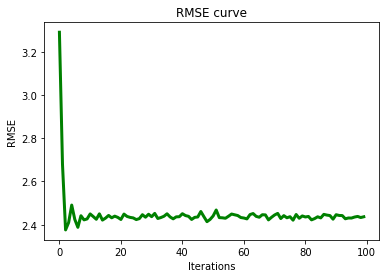

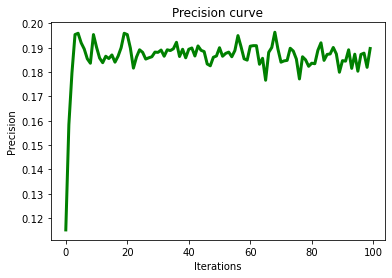

In [19]:
# All the same procedure with the MLP. The only difference is the model structure.
hidden_size = 50        
lamda_regularizer = 1e-2 
learning_rate = 0.01 
dropout_rate = 0.5         
model = cdae(users_num = users_num,
             items_num = items_num,
             hidden_size = hidden_size,
             batch_size = batch_size,
             learning_rate = learning_rate,
             lamda_regularizer = lamda_regularizer,
             dropout_rate = dropout_rate)

user_array = np.array([u for u in range(users_num)])
input_data = np.c_[user_array, train_mat]
records_list = []
for epoch in range(epoches):
    data_mat = np.random.permutation(input_data) 
    loss = model.train(data_mat=data_mat)
    pred_mat = model.predict_ratings(data_mat=np.c_[user_array, train_mat])
    mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
    records_list.append([loss[-1],mae, rmse, recall, precision])
    if epoch % 10==0:
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision))

figure(values_list=np.array(records_list)[:,0],name='loss')
figure(values_list=np.array(records_list)[:,2],name='RMSE')
figure(values_list=np.array(records_list)[:,-1],name='Precision')

- <strong>Item(movie) based.</strong>

epoch:0  loss=8.1307; 
 MAE=2.5390; RMSE=2.8111; Recall=0.0350; Precision=0.0741
epoch:10  loss=4.2898; 
 MAE=2.2812; RMSE=2.5880; Recall=0.0896; Precision=0.1900
epoch:20  loss=4.1073; 
 MAE=2.2790; RMSE=2.5824; Recall=0.0887; Precision=0.1882
epoch:30  loss=4.2807; 
 MAE=2.2333; RMSE=2.5470; Recall=0.0882; Precision=0.1872
epoch:40  loss=4.1220; 
 MAE=2.2440; RMSE=2.5586; Recall=0.0891; Precision=0.1890
epoch:50  loss=3.8063; 
 MAE=2.2569; RMSE=2.5642; Recall=0.0868; Precision=0.1842
epoch:60  loss=4.0782; 
 MAE=2.2741; RMSE=2.5791; Recall=0.0886; Precision=0.1878
epoch:70  loss=4.3228; 
 MAE=2.2770; RMSE=2.5837; Recall=0.0892; Precision=0.1892
epoch:80  loss=5.0516; 
 MAE=2.2537; RMSE=2.5656; Recall=0.0880; Precision=0.1866
epoch:90  loss=4.0611; 
 MAE=2.2793; RMSE=2.5856; Recall=0.0890; Precision=0.1887


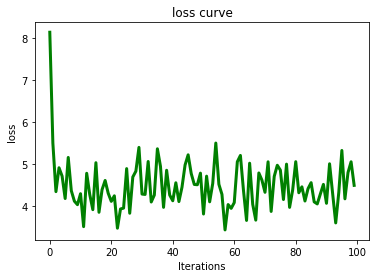

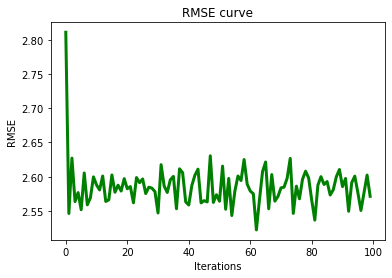

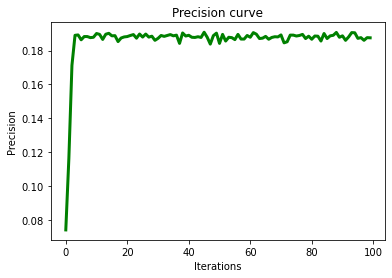

In [20]:
model = cdae(users_num = items_num,
             items_num = users_num,
             hidden_size = hidden_size,
             batch_size = batch_size,
             learning_rate = learning_rate,
             lamda_regularizer = lamda_regularizer,
             dropout_rate = dropout_rate)

item_array = np.array([i for i in range(items_num)])
input_data = np.c_[item_array, train_mat.T]
records_list = []
for epoch in range(epoches):
    data_mat = np.random.permutation(input_data) 
    loss = model.train(data_mat=data_mat)
    
    pred_mat = model.predict_ratings(data_mat=np.c_[item_array, train_mat.T]) # Compare1
    mae, rmse, recall, precision = evaluation(pred_mat.T, train_mat, test_mat) # Compare2
    
    ### This is what used in User based filtering. Note the difference
    # pred_mat = model.predict_ratings(data_mat=np.c_[user_array, train_mat]) # Compare1
    # mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat) # Compare2
    
    records_list.append([loss[-1],mae, rmse, recall, precision])
    if epoch % 10==0:
        print('epoch:%d  loss=%.4f; \n MAE=%.4f; RMSE=%.4f; Recall=%.4f; Precision=%.4f'
              %(epoch, loss[-1], mae, rmse, recall, precision))

figure(values_list=np.array(records_list)[:,0],name='loss')
figure(values_list=np.array(records_list)[:,2],name='RMSE')
figure(values_list=np.array(records_list)[:,-1],name='Precision')

<h3>Comparisons and Discussion</h3>

<h3>For the MLP</h3>

![images](./images/MLP-structure.png)

Note that we use an Embdedding layer here to reduce the dimensional space of the input vectors. It is too spares (One user may only see several movies and left all the other ratings 0).

The Loss function of MLP for recommand system is:

![images](./images/MLP_Loss_function.png)

Note that <strong>O</strong> mean the interaction of user and item while <strong>O-</strong> means the other parts. Hence in set <strong>O</strong> we have y_{u}{i} = 1, and in <strong>O-</strong> we have y_{u}{i} = 0

<h3>For CDAE,</h3>

![images](./images/Auto-Encoder.png)

Note the difference between CDAE and normal AE is that we have noise and dropout sampling in the inputs. Therefore it can deal with overfitting better.

![images](./images/Auto-loss.png)

Note that W is the movies' weight (W' is the weight in output) while V is users' weight. y^(~) is the input after dropout sampling and y is the output.

<h4>After comparsion we can find the CDAE performs better then MLP in RMSE (Accuracy is not a good benchmark). This is what we expected.</h4>

<h4>Then I am going to compare the result of part1 and part2</h4>

Generally speaking part1 is doing recommandation based on rules and it depends on nearest neighbours. The standard procedure of finding k nearest neighbours is:
    1. Find the distances between the data points based on Pearson correlation，Cosine，Squared Distance etc
    2. Select the nearest neighbours.
    3. Make predictions based on this.

This method is not as advanced as part2's Deep Learning based methods because of many reasons. I am going to introduce the sparsity of data and embedding. Let's use Pearson correlation as an example. The equation of Pearson correlation is like this:

![images](./images/P1.png)

and we have to use this equation to perform predictions

![images](./images/P2.png)

where the S^(~)_{m}{n} is calculated by

![images](./images/P4.png)

We can clearly see if the dataset is too big then the overlap between to users' choice becomes very small. From the expression we know if two movies have small overlap then the S will become very small, which indicates the degree of similarity between them is not reliable. In the big and sparse data, the small overlaps appears everywhere and it will significantly reduce the reliability of the system. To solve this problem, we add embeddings in the DL models and it solve this problem very well.